Loading data...
Dataset shape: (4898430, 42)
Creating binary labels...
Class distribution:
binary_label
attack    3925650
normal     972780
Name: count, dtype: int64
Preparing features and target...
Splitting data into training and testing sets...
Training set shape: (3428901, 41)
Testing set shape: (1469529, 41)
Creating and training Random Forest model...
Model training completed.

Evaluating model...
Accuracy: 0.9998

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    291834
      Attack       1.00      1.00      1.00   1177695

    accuracy                           1.00   1469529
   macro avg       1.00      1.00      1.00   1469529
weighted avg       1.00      1.00      1.00   1469529

Confusion matrix saved as 'confusion_matrix.png'

Analyzing feature importance...

Top 20 Most Important Features:
                         Feature  Importance
2                      dst_bytes    0.167006
19                  

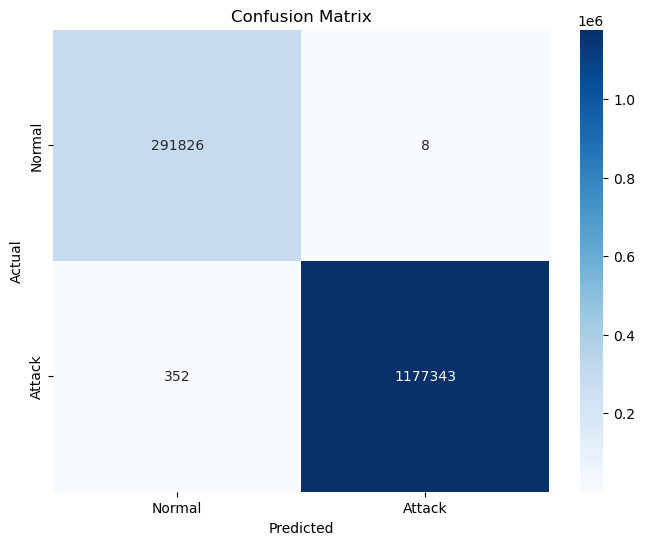

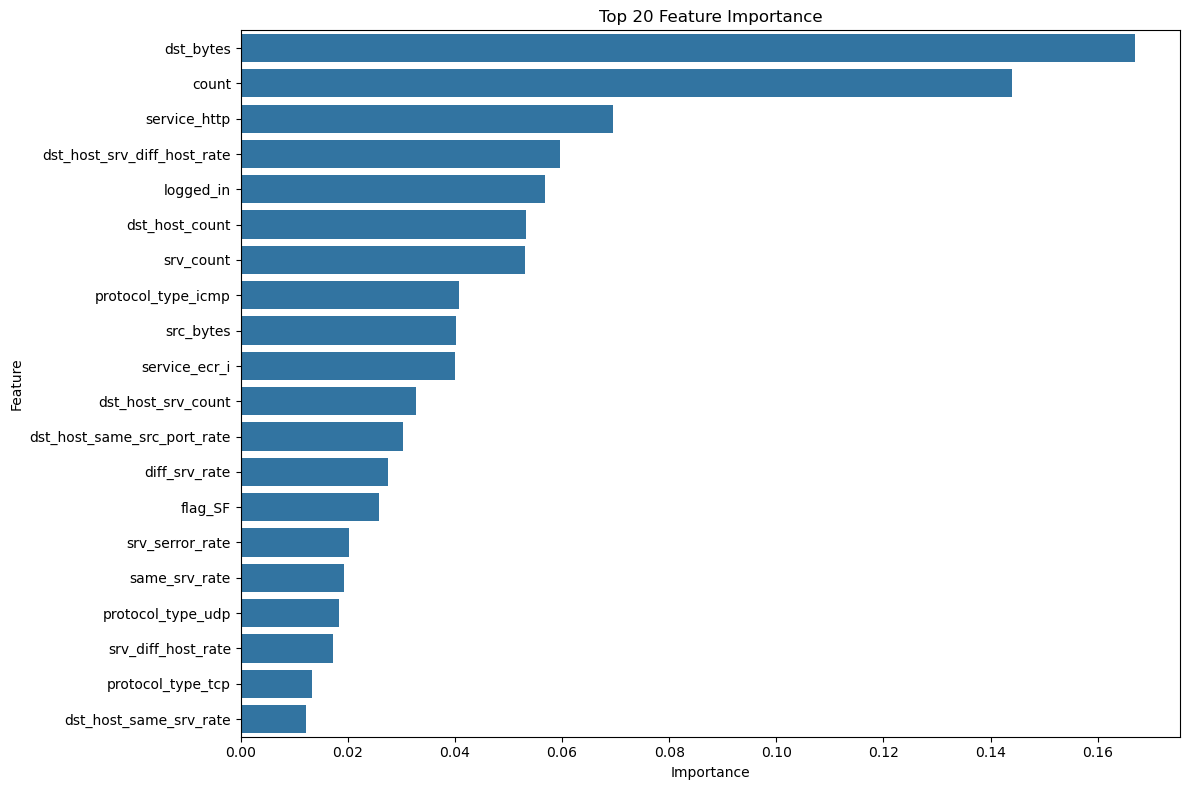

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define column names based on the dataset description
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_hot_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

def main():
    try:
        # Step 1: Load data
        print("Loading data...")
        # Updated to handle txt file with comma-separated values and no header
        data = pd.read_csv('kddcup.data.txt', header=None, names=column_names, sep=',', on_bad_lines='skip')
        print(f"Dataset shape after skipping bad lines: {data.shape}")
        
        # Step 2: Create binary labels (attack vs normal)
        print("Creating binary labels...")
        data['binary_label'] = data['label'].apply(
            lambda x: 'normal' if x == 'normal.' else 'attack'
        )
        print(f"Class distribution:\n{data['binary_label'].value_counts()}")
        
        # Step 3: Split features and target
        print("Preparing features and target...")
        # Identify categorical and numerical features
        categorical_features = ['protocol_type', 'service', 'flag']
        numerical_features = [col for col in data.columns 
                             if col not in categorical_features + ['label', 'binary_label']]
        
        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])
        
        # Prepare X (features) and y (target)
        X = data.drop(['label', 'binary_label'], axis=1)
        y = (data['binary_label'] == 'attack').astype(int)  # 1 for attack, 0 for normal
        
        # Step 4: Split the data into training and testing sets
        print("Splitting data into training and testing sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        print(f"Training set shape: {X_train.shape}")
        print(f"Testing set shape: {X_test.shape}")
        
        # Step 5: Create and train the model
        print("Creating and training Random Forest model...")
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=100,  # Number of trees
                max_depth=10,      # Maximum depth of trees
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1  # Use all available cores
            ))
        ])
        
        model.fit(X_train, y_train)
        print("Model training completed.")
        
        # Step 6: Evaluate the model
        print("\nEvaluating model...")
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
        
        # Create and plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Normal', 'Attack'],
                   yticklabels=['Normal', 'Attack'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        print("Confusion matrix saved as 'confusion_matrix.png'")
        
        # Step 7: Analyze feature importance
        print("\nAnalyzing feature importance...")
        # Get feature names after preprocessing
        ohe_feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(
            categorical_features
        )
        feature_names = numerical_features + list(ohe_feature_names)
        
        # Get feature importances
        importances = model.named_steps['classifier'].feature_importances_
        
        # Create a DataFrame for better visualization
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Display top 20 most important features
        print("\nTop 20 Most Important Features:")
        print(feature_importance.head(20))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Top 20 Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        print("Feature importance plot saved as 'feature_importance.png'")
        
        print("\nModel training and evaluation completed successfully.")
        
    except Exception as e:
        print(f"An error occurred during execution: {e}")

if __name__ == "__main__":
    main()